In [2]:
# Amazon UK Product Insights - EDA Bivariate Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, probplot
from sklearn.preprocessing import LabelEncoder

# Set aesthetics for seaborn
sns.set(style="whitegrid")

# Load dataset
df = pd.read_csv("/Users/irynaoleinikova/Documents/Ironhack/Ironhack_labs/amz_uk_price_prediction_dataset.csv")

# Display basic info
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB
None


,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [4]:
#Part 1
# Crosstab between product category and isBestSeller
crosstab = pd.crosstab(df['category'], df['isBestSeller'], normalize='index')
crosstab['best_seller_ratio'] = crosstab[True] if True in crosstab.columns else 0
top_bestseller_cats = crosstab.sort_values(by='best_seller_ratio', ascending=False)
top_bestseller_cats[['best_seller_ratio']].head(10)


isBestSeller,best_seller_ratio
category,
Grocery,0.058135
Smart Home Security & Lighting,0.057692
Health & Personal Care,0.057686
Mobile Phone Accessories,0.042471
Power & Hand Tools,0.035339
"Billiard, Snooker & Pool",0.032129
Pet Supplies,0.030200
Home Brewing & Wine Making,0.028455
Wind Instruments,0.028000


In [6]:
# Chi-Square Test + Cramér's V
# Chi-square test
contingency_table = pd.crosstab(df['category'], df['isBestSeller'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cramér's V
n = contingency_table.sum().sum()
phi2 = chi2/n
r, k = contingency_table.shape
cramers_v = np.sqrt(phi2 / min(k-1, r-1))

print(f"Chi2: {chi2}, p-value: {p}")
print(f"Cramér's V: {cramers_v}")



Chi2: 36540.20270061387, p-value: 0.0
Cramér's V: 0.1222829439760564


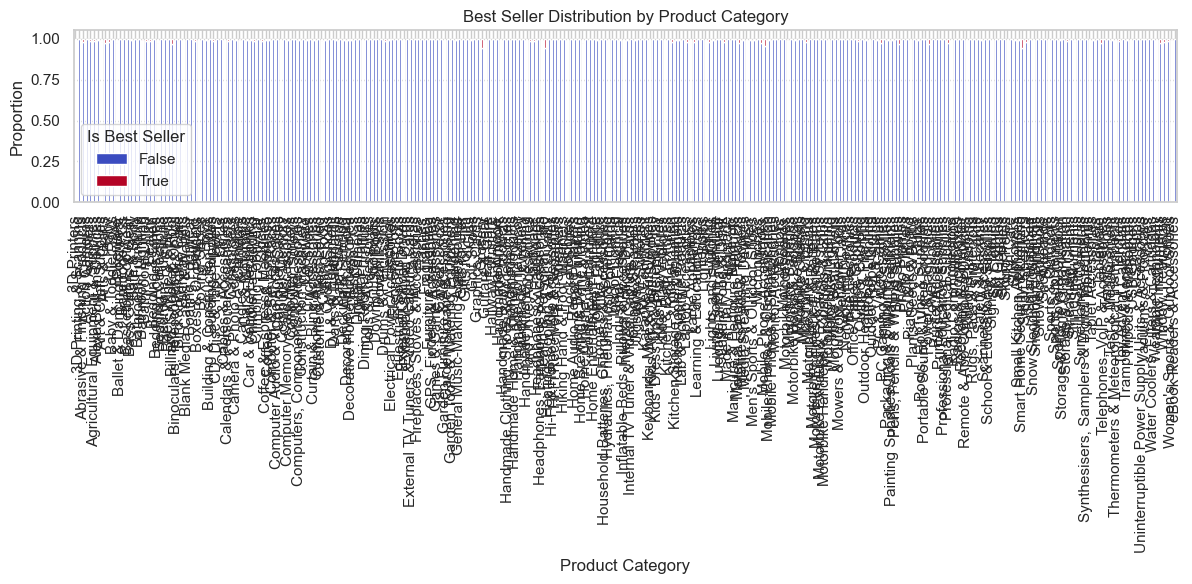

In [7]:
# Stacked bar chart
contingency_table.div(contingency_table.sum(1), axis=0).plot(kind='bar', stacked=True, figsize=(12,6), colormap='coolwarm')
plt.title("Best Seller Distribution by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Proportion")
plt.legend(title="Is Best Seller")
plt.tight_layout()
plt.show()


In [8]:
# Part 2
# Removed Price Outliers (IQR Method)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_filtered = df[(df['price'] >= lower) & (df['price'] <= upper)]



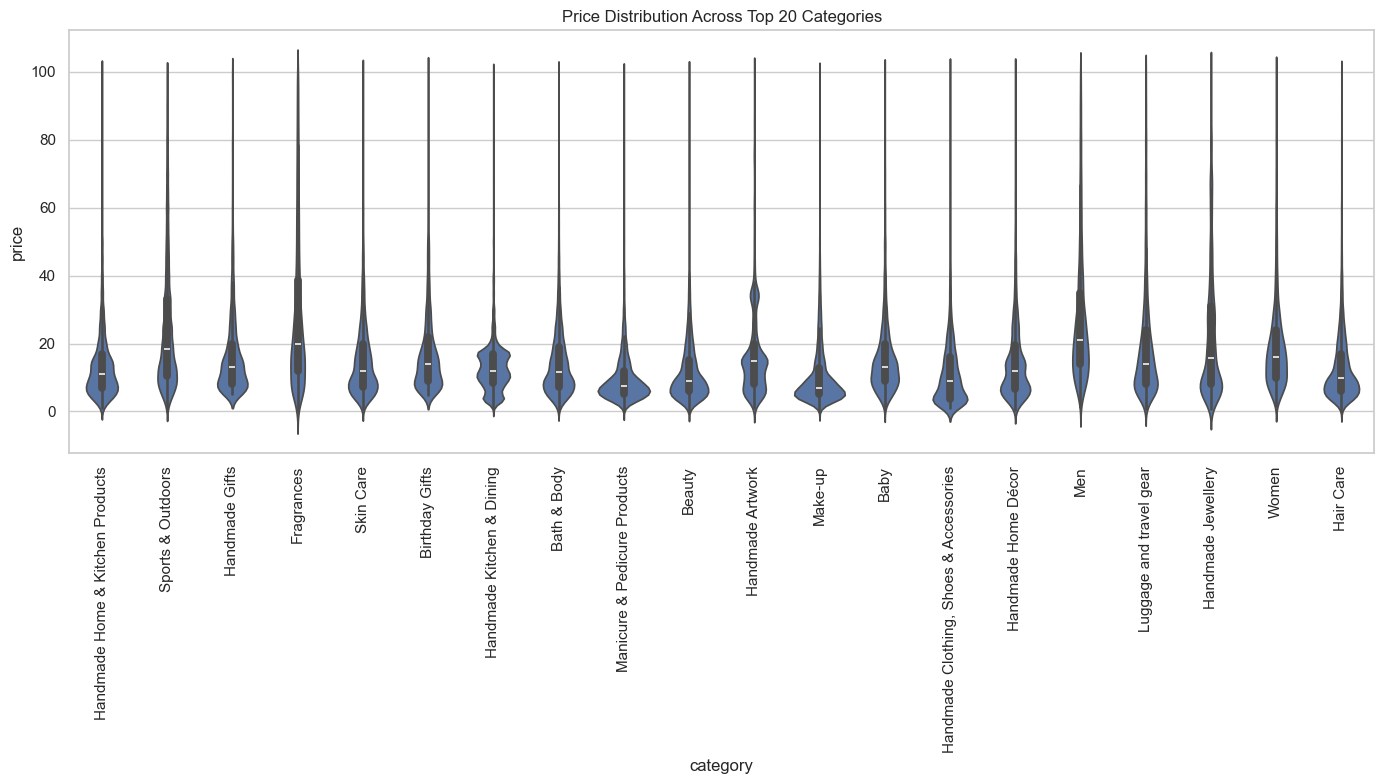

In [9]:
# Violin Plot – Price by Category (Top 20)
top_20_cats = df_filtered['category'].value_counts().head(20).index
plt.figure(figsize=(14, 8))
sns.violinplot(data=df_filtered[df_filtered['category'].isin(top_20_cats)], 
               x='category', y='price')
plt.xticks(rotation=90)
plt.title("Price Distribution Across Top 20 Categories")
plt.tight_layout()
plt.show()


In [10]:
# Median Price by Category (All Categories)
median_prices = df_filtered.groupby('category')['price'].median().sort_values(ascending=False)
print("Top categories by median price:")
print(median_prices.head(5))


Top categories by median price:
category
Desktop PCs       74.00
Boxing Shoes      69.79
Tablets           69.00
Graphics Cards    68.54
Motherboards      67.92
Name: price, dtype: float64


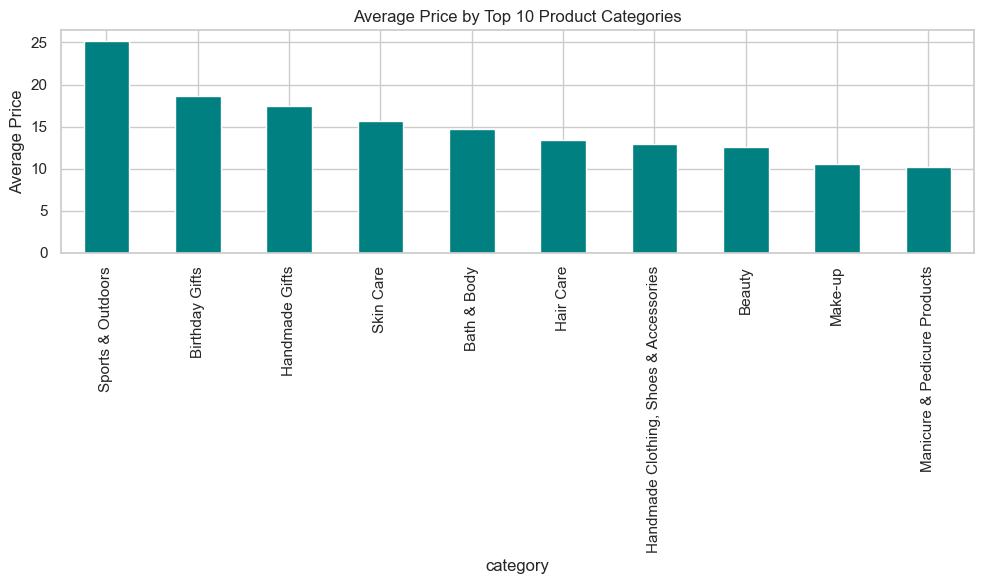

In [11]:
# Average Price Bar Chart – Top 10 Categories by Count
top_10_cats = df_filtered['category'].value_counts().head(10).index
avg_prices = df_filtered[df_filtered['category'].isin(top_10_cats)].groupby('category')['price'].mean()

avg_prices.sort_values(ascending=False).plot(kind='bar', figsize=(10,6), color='teal')
plt.title("Average Price by Top 10 Product Categories")
plt.ylabel("Average Price")
plt.tight_layout()
plt.show()


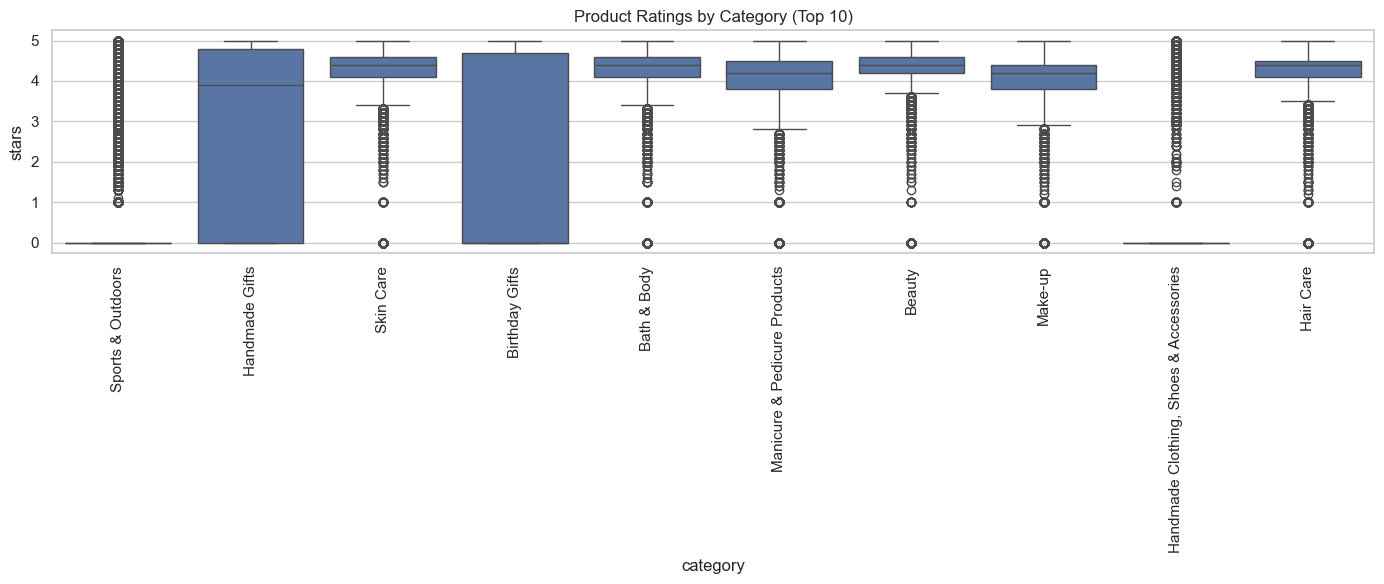

Top categories by median rating:
category
Computer Memory                 4.7
Building & Construction Toys    4.6
Office Paper Products           4.6
Luxury Food & Drink             4.6
Kids' Play Figures              4.6
Name: stars, dtype: float64


In [12]:
# Box Plot – Ratings by Category (Top 10)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_filtered[df_filtered['category'].isin(top_10_cats)], 
            x='category', y='stars')
plt.xticks(rotation=90)
plt.title("Product Ratings by Category (Top 10)")
plt.tight_layout()
plt.show()

# Median rating by category (all)
median_ratings = df_filtered.groupby('category')['stars'].median().sort_values(ascending=False)
print("Top categories by median rating:")
print(median_ratings.head(5))


In [13]:
# Part 3  Prices vs Ratings
# Correlation Coefficient
correlation, p_value = pearsonr(df_filtered['price'], df_filtered['stars'])
print(f"Correlation between price and rating: {correlation:.3f} (p = {p_value:.3f})")


Correlation between price and rating: -0.078 (p = 0.000)


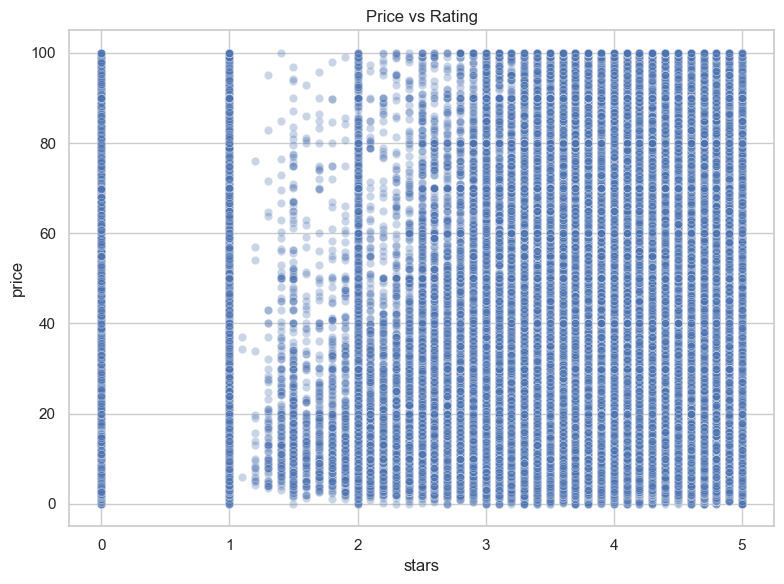

In [ ]:
# Scatter Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_filtered, x='stars', y='price', alpha=0.3)
plt.title("Price vs Rating")
plt.tight_layout()
plt.show()


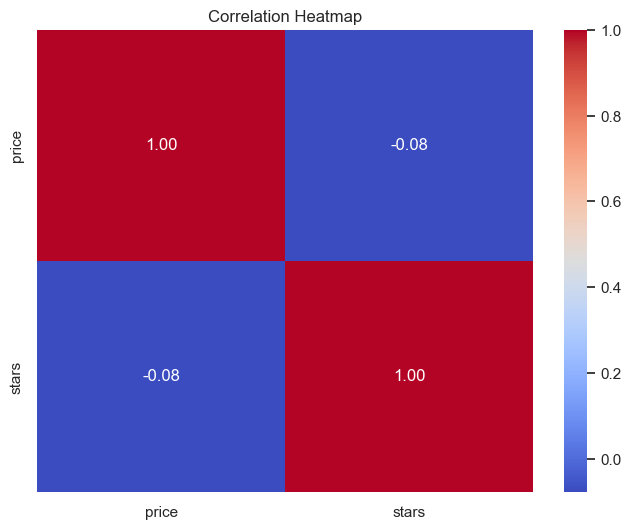

In [16]:
# Heatmap – Numerical Correlation
plt.figure(figsize=(8,6))
sns.heatmap(df_filtered[['price', 'stars']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


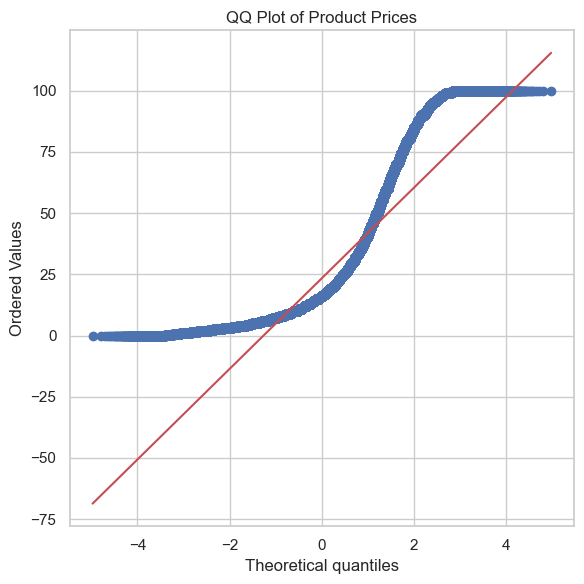

In [17]:
# QQ Plot – Price Distribution
plt.figure(figsize=(6,6))
probplot(df_filtered['price'], dist="norm", plot=plt)
plt.title("QQ Plot of Product Prices")
plt.tight_layout()
plt.show()
